<a href="https://colab.research.google.com/github/krishConqueror0609/Tinkers/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Model Testing Accuracy:
--------------------------------------------------
Testing Accuracy: 0.8628
Training Accuracy: 0.8232

Model Performance Metrics:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89       266
         1.0       0.80      0.85      0.82       164

    accuracy                           0.86       430
   macro avg       0.85      0.86      0.86       430
weighted avg       0.86      0.86      0.86       430


Feature Importance:
                 Feature  Coefficient
19  FunctionalAssessment     3.824402
0                    ADL     3.676645
22                  MMSE     2.534049
23      MemoryComplaints     2.433476
4     BehavioralProblems     2.266525
1                    Age     0.569986
6         CholesterolHDL     0.382961
34      EducationLevel_3     0.321722
10             Confusion     0.272294
7         CholesterolLDL     0.265181


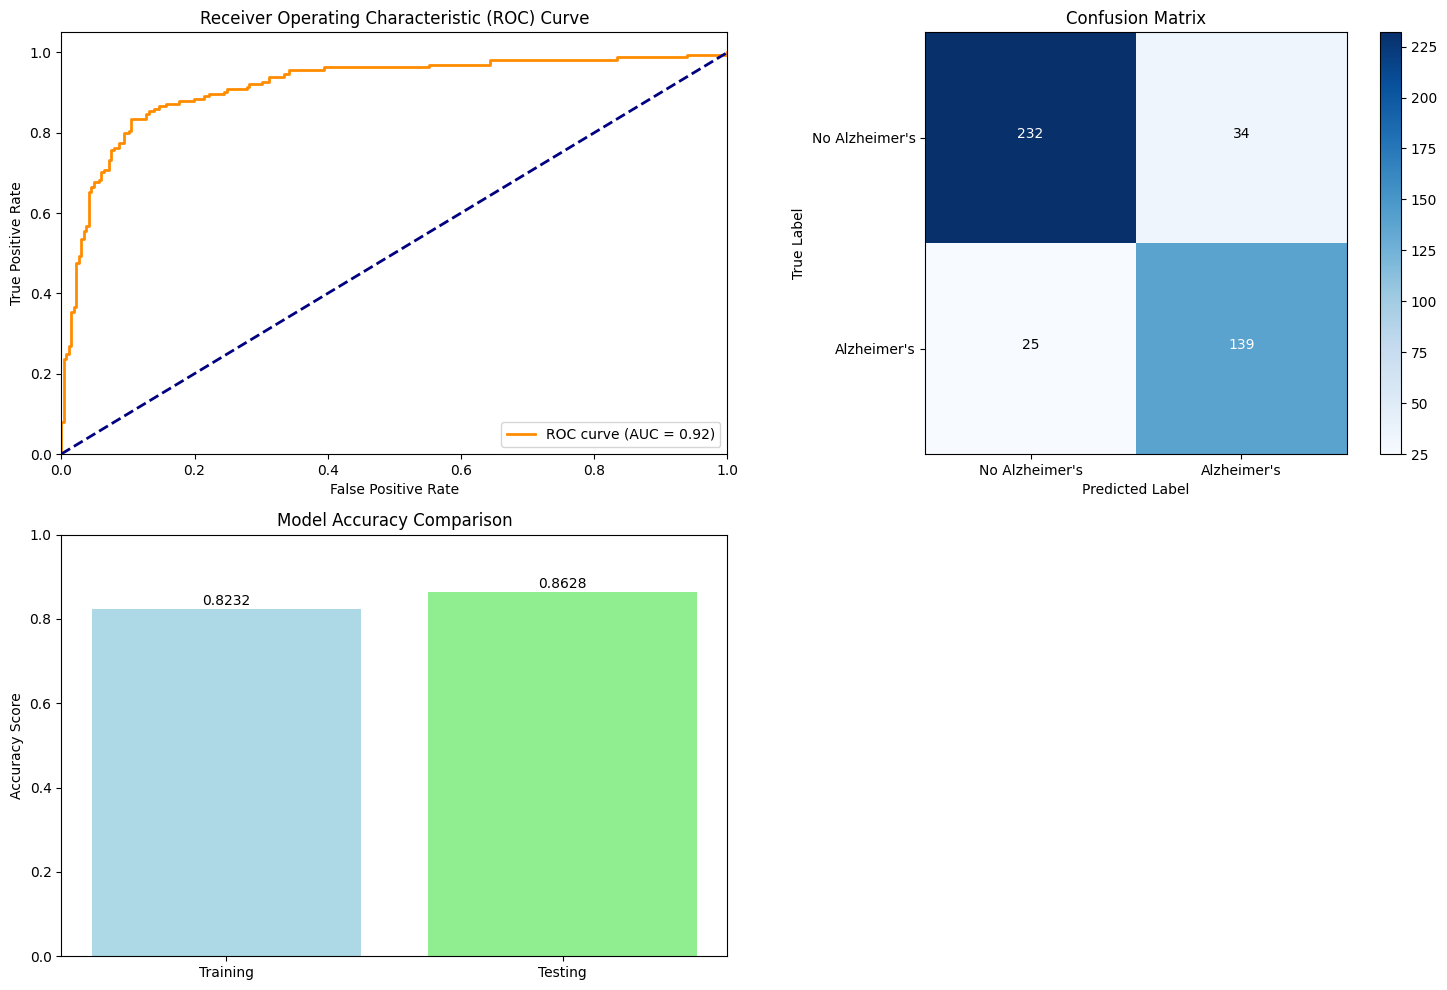

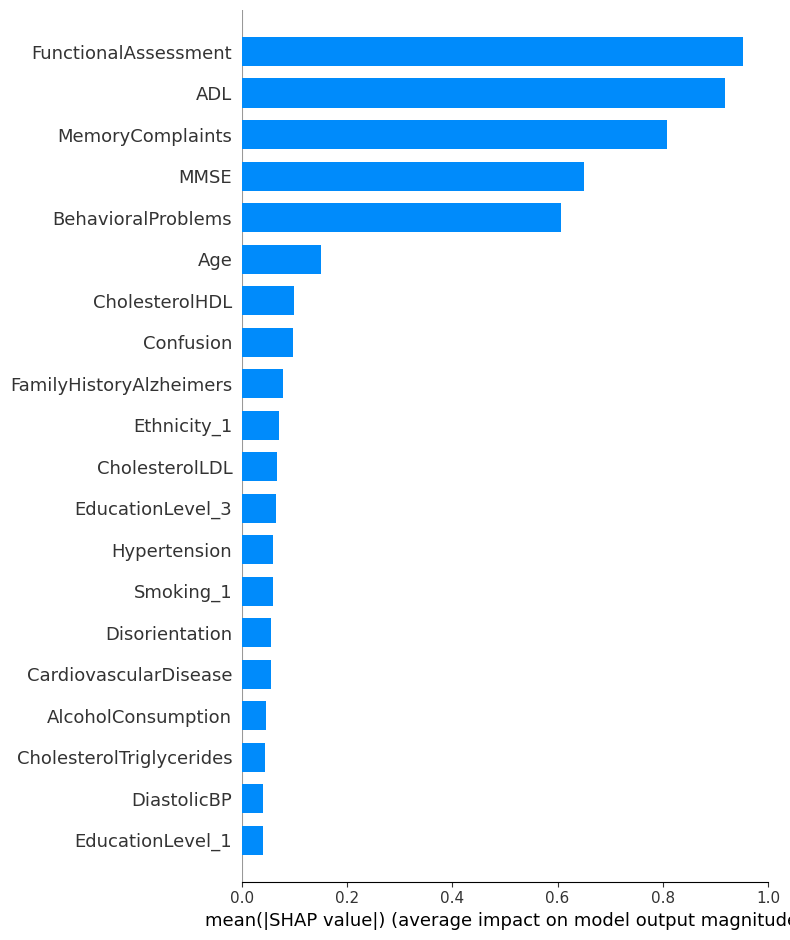

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import shap

# Load the preprocessed dataset
file_path = 'processed_alzehaimers.csv'  # Replace with your file path
data = pd.read_csv("/content/processed_alzehaimers.csv")

# Split features and target
X = data.drop(columns=['Diagnosis_1'])
y = data['Diagnosis_1']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(
    max_iter=1000,          # Increase max iterations for convergence
    C=1.0,                  # Inverse of regularization strength
    class_weight='balanced' # Handle class imbalance
)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
y_pred = lr_model.predict(X_test)

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("\nModel Testing Accuracy:")
print("-" * 50)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Calculate training accuracy
y_train_pred = lr_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Print model performance metrics
print("\nModel Performance Metrics:")
print("-" * 50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(lr_model.coef_[0])
})
print(feature_importance.sort_values('Coefficient', ascending=False).head(10))

# Visualizations
plt.figure(figsize=(15, 10))  # Increased figure size for 3 subplots

# Plot 1: ROC Curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot 2: Confusion Matrix
plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Alzheimer\'s', 'Alzheimer\'s'])
plt.yticks(tick_marks, ['No Alzheimer\'s', 'Alzheimer\'s'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to confusion matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Plot 3: Accuracy Comparison
plt.subplot(2, 2, 3)
accuracies = {'Training': train_accuracy, 'Testing': test_accuracy}
plt.bar(accuracies.keys(), accuracies.values(), color=['lightblue', 'lightgreen'])
plt.ylim([0, 1.0])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# SHAP Analysis with error handling
try:
    # Convert to numpy arrays
    X_train_np = X_train.values
    X_test_np = X_test.values

    # Create background data for SHAP
    background_data = shap.maskers.Independent(X_train_np, max_samples=100)

    # Create and fit the SHAP explainer
    explainer = shap.LinearExplainer(lr_model, background_data)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_np)

    # Create new figure for SHAP plot
    plt.figure(figsize=(10, 6))

    # If shap_values is a single array
    if isinstance(shap_values, np.ndarray):
        shap.summary_plot(
            shap_values,
            X_test,
            feature_names=list(X.columns),
            plot_type="bar",
            show=False
        )
    # If shap_values is a list (for binary classification)
    else:
        shap.summary_plot(
            shap_values[1] if isinstance(shap_values, list) else shap_values,
            X_test,
            feature_names=list(X.columns),
            plot_type="bar",
            show=False
        )

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in SHAP analysis: {str(e)}")
    print("Falling back to basic feature importance plot")

    # Create basic feature importance plot as fallback
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(lr_model.coef_[0])
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=True)

    plt.barh(range(len(feature_importance)), feature_importance['Importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance in Logistic Regression Model')
    plt.tight_layout()
    plt.show()